state for agent 0: {'physical_observation': [0, 0], 'communication_observation': None}
physical action for agent 0: 8
state for agent 1: {'physical_observation': [0, 0], 'communication_observation': None}
physical action for agent 1: 0
Agent 0 sends message: (8, None)
Agent 1 sends message: (0, None)
state for agent 0: [0, 0, None]
physical action for agent 0: 0
state for agent 1: [0, 0, None]
physical action for agent 1: 6
Agent 0 sends message: (0, None)
Agent 1 sends message: (6, None)
state for agent 0: [0, 0, None]
physical action for agent 0: 6
state for agent 1: [0, 0, None]
physical action for agent 1: 4
Agent 0 sends message: (6, None)
Agent 1 sends message: (4, None)
state for agent 0: [0, 0, None]
physical action for agent 0: 2
state for agent 1: [1, 0, None]
physical action for agent 1: 2
Agent 0 sends message: (2, None)
Agent 1 sends message: (2, None)
state for agent 0: [0, 1, None]
physical action for agent 0: 7
state for agent 1: [1, 1, None]
physical action for agent 1

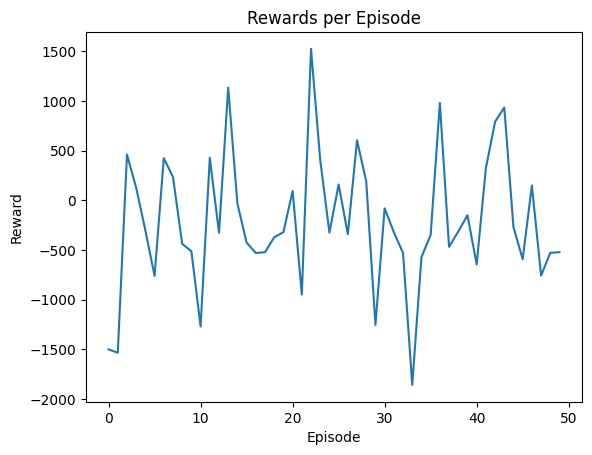

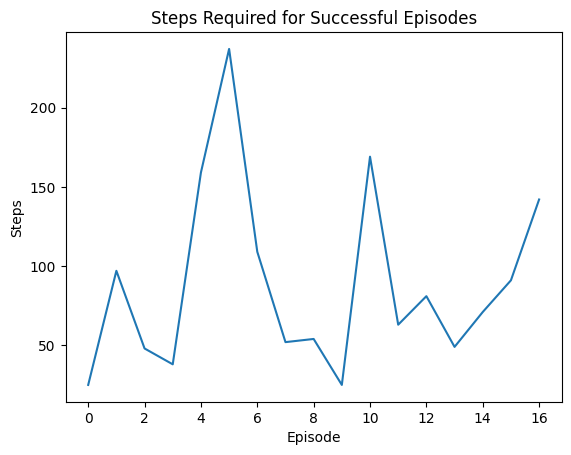

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from environment_ma import Env

class QLearningAgent:
    def __init__(self, env, actions):
        self.env = env
        self.actions = actions
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        self.epsilon = 0.1
        self.q_tables = [defaultdict(lambda: [0.0] * len(actions)) for _ in range(env.num_agents)]
        self.rewards_per_episode = []

    def learn(self, agent_idx, state, action, reward, next_state, comm_action):
        current_q = self.q_tables[agent_idx][state][action]
        max_next_q = max(self.q_tables[agent_idx][next_state])
        new_q = (current_q + self.learning_rate *
                (reward + self.discount_factor * max_next_q - current_q))
        self.q_tables[agent_idx][state][action] = new_q
        
        # Update q-table with communication action if it's not None
        if comm_action is not None:
            print(f"Agent {agent_idx} sends message: {comm_action}")
            # You can update q-table with communication action here if needed

    def get_action(self, agent_idx, state):
        if np.random.rand() < self.epsilon:
            state_action = self.q_tables[agent_idx][state]
            action = self.arg_max(state_action)
        else:
            action = np.random.choice(len(self.actions))
        return action

    def choose_action(self, agent_idx, state):
        physical_action = self.get_action(agent_idx, state)
        if self.env.is_agent_silent:
            communication_action = None
        else:
            communication_action = f"Message from agent {agent_idx}"
            
        return (physical_action, communication_action)


    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

    def run_episodes(self, num_episodes):
        success_count = 0
        success_steps = []

        for episode in range(num_episodes):
            states = self.env.reset()
            total_reward = 0
            step_count = 0
            done = [False] * self.env.num_agents

            while not all(done):
                joint_actions = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    physical_action, comm_action = self.choose_action(agent_idx, str(state))
                    print(f"state for agent {agent_idx}: {state}")
                    print(f"physical action for agent {agent_idx}: {physical_action}")
                    print(f"comm action for agent {agent_idx}: {comm_action}")
                    joint_actions.append((physical_action, comm_action))

                next_states, rewards, done = self.env.step(joint_actions)

                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    physical_action = joint_actions[agent_idx][0]
                    reward = rewards[agent_idx]
                    next_state = next_states[agent_idx]
                    comm_action = joint_actions[agent_idx][1]

                    self.learn(agent_idx, str(state), physical_action, reward, str(next_state), comm_action)
                    total_reward += reward
                    states[agent_idx] = next_state

                step_count += 1

            self.rewards_per_episode.append(total_reward)
            if total_reward > 0:
                success_count += 1
                success_steps.append(step_count)
            print(f"Episode: {episode + 1}, Reward: {total_reward}")

        success_rate = success_count / num_episodes * 100
        print(f"Success rate: {success_rate}%")
        self.plot_rewards_per_episode()
        self.plot_success_steps(success_steps)

    def plot_rewards_per_episode(self):
        plt.plot(self.rewards_per_episode)
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.show()

    @staticmethod
    def plot_success_steps(success_steps):
        plt.plot(success_steps)
        plt.title('Steps Required for Successful Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
        plt.show()


if __name__ == "__main__":
    num_agents = 2
    is_agent_silent = False  # Set to True or False to enable/disable communication
    env = Env(num_agents=num_agents, is_agent_silent=is_agent_silent)
    actions = list(range(5)) + [(i, 'send') for i in range(5)]
    agent = QLearningAgent(env, actions)

    agent.run_episodes(50)
